In [288]:
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2
from nerf2d import NeRF2D_LightningModule

# load trained NeRF
nerf = NeRF2D_LightningModule.load_from_checkpoint('checkpoints/last.ckpt').cpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [291]:
from torch.utils.data import DataLoader
from pathlib import Path
from nerf2d_dataset import read_image_folder, NeRFDataset2D

# read test set
dataset_folder = Path('/home/jorge/repos/NeRF2D/data/cube')
ims, poses, focal, depths = read_image_folder(dataset_folder / 'test')
dataset = NeRFDataset2D(ims, poses, focal, depths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

def show_colors(colors, names=None):
    if names is None:
        names = [''] * len(colors)

    fig, ax = plt.subplots(1, len(colors), figsize=(len(colors), 1))
    for i, color in enumerate(colors):
        ax[i].imshow(color.expand(1, 1, 3).detach().numpy())
        ax[i].set_axis_off()
        ax[i].set_title(names[i])

    plt.show()

def get_nth_batch(n, loader):
    for i, batch in enumerate(loader):
        if i == n:
            return batch

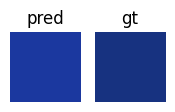

tensor([[2.9941]])
torch.Size([1, 1])


tensor(0.0054, grad_fn=<MseLossBackward0>)

In [293]:
# get batch and evaluate it
o, d, color_gt, depth_gt = get_nth_batch(20, dataloader)
color_pred, weights, ts = nerf(o, d)

show_colors([color_pred[0], color_gt[0]], ['pred', 'gt'])

print(depth_gt)
print(depth_gt.shape)

color_loss = nerf.color_loss(color_pred, color_gt)
color_loss

Ensure weights sum to one tensor([1.0000], grad_fn=<SumBackward1>)
g.t depth tensor([2.9941])
tensor([1.0000], grad_fn=<SumBackward1>)


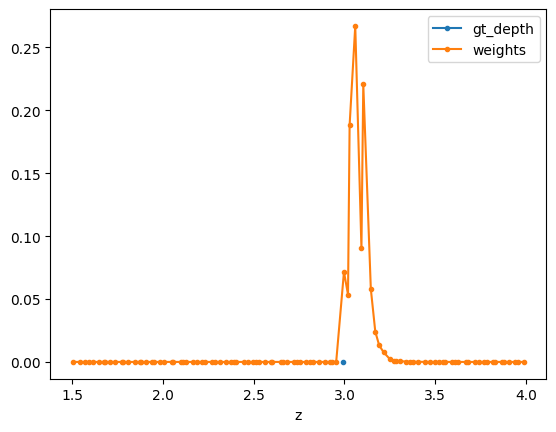

In [313]:
print('Ensure weights sum to one', weights.sum(dim=1))
print('g.t depth', depth_gt[0])

fig, ax = plt.subplots()

print(weights.sum(dim=1))

plt.plot([depth_gt[0]], [0], label='gt_depth', marker='.')

ax.plot(ts.detach().numpy(), weights[0].detach().numpy(), label='weights', marker='.')
ax.set_xlabel('z')
ax.legend()
plt.show()



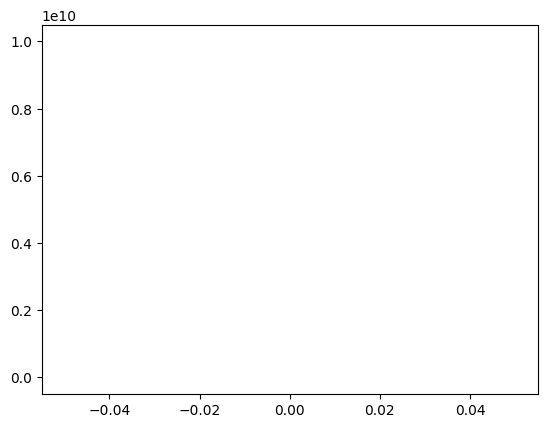

tensor([8.1181e+08], grad_fn=<SumBackward1>)

In [333]:

from torch import Tensor

def depth_loss(ts, weights, depth, sigma=0.1):
    """
    ts: T
    weights: N,T
    depth: N,1
    """

    delta = ts[1:] - ts[:-1]
    delta = torch.cat([delta, Tensor([1e10])], dim=0).unsqueeze(0)

    plt.plot(torch.linspace(0, 1, len(delta)), delta)
    plt.show()

    loss1 = -torch.log(weights + 1e-5)
    loss2 = torch.exp(-(ts - depth) ** 2 / (2 * sigma)) * delta
    loss = loss1 * loss2
    loss = loss.sum(dim=1)

    return loss

depth_loss(ts, weights, depth_gt)

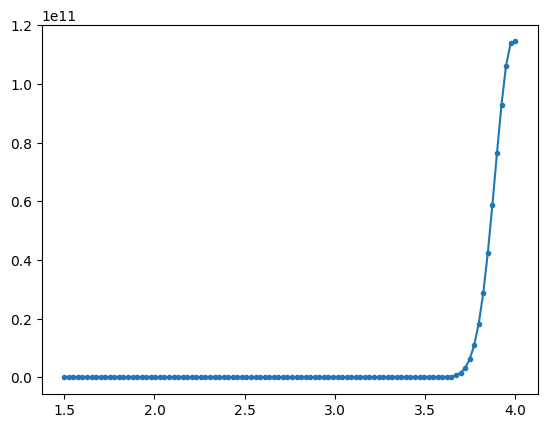

In [329]:
depth_loss(ts, weights, depth_gt)

gt_depths = torch.linspace(1.5, 4, 100)

losses = []
for gt_depth in gt_depths:
    loss = depth_loss(ts, weights, torch.Tensor([[gt_depth]]), 0.01)
    losses.append(loss.item())

plt.plot(gt_depths, losses, marker='.')

